In [1]:
import numpy as np
import os
os.chdir('..')


from rss import rSNAPsim
from rss import ProbeVectorFactory as pvf
from rss import PropensityFactory as pff
from rss import TranslationSolvers as tss
from rss import TranslationOptimization as topt
from rss import IntensityData as data_obj
from rss import IntensityAnalyses as int_a
os.chdir('./interactive_notebooks')

import matplotlib.pyplot as plt
import time


rsim = rSNAPsim()
rsim.open_seq_file('../gene_files/Bactin_withTags.txt')
poi = rsim.proteins['1'][0]  #protein object
solver = tss()  #solver class
solver.protein=poi
t = np.linspace(0,500,501)



.\generalized_cpp
importing models


### Lets generate a simulated data object with a specific parameter set

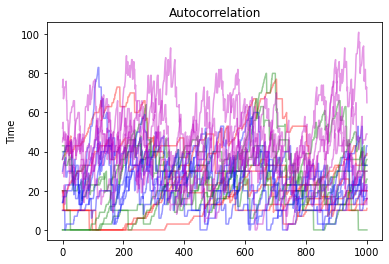

In [6]:

ki = [.01,.02,.04,.1]
ke = [ 2, 4, 7 , 10]
colors = ['r','g','b','m']
for i in range(4):
        
    poi.ke_mu = ke[i] #half the speed
    solver.default_conditions['burnin'] = 1000 #lets burnin for 1000s
    solver.t = np.linspace(0,2000,2001)
    solver.n_traj = 30
    t = np.linspace(0,2000,2001)
    ssa_soln = solver.solve_ssa([ki[i]] + poi.kelong + [10],t,n_traj=5)                
    plt.plot(ssa_soln.intensity_vec[0],color=colors[i],alpha=.4)
    sim_data = data_obj()
    sim_data.add_data(ssa_soln.time,ssa_soln.intensity_vec)
    sim_data.get_stats()

    sim_acov, sim_acov_err = int_a().get_autocov(sim_data.intensity_vec,norm='ind')
    sim_acc, sim_acc_err = int_a().get_autocorr(sim_acov)
    sim_data.acorr = sim_acc
    sim_data.acorr_err = sim_acc_err

    plt.title('Intensity Trajectories')
    plt.ylabel('Time')

    #plt.figure()
    #plt.plot(sim_data.times,sim_data.acorr[0], alpha=.1,color='b')
    #plt.plot(sim_data.times,np.mean(sim_data.acorr[0],axis=1),color='r',lw=2)

    plt.title('Autocorrelation')
    plt.ylabel('Time')
    a=1


In [3]:
opt = topt()  #Optimization object
opt.solver_obj = solver
opt.data_obj = sim_data
opt.parnames = ['ki','ke']
true_par = [.08,5]
opt.opts['bounds'] = ([0.01,.17],[0.1,12])

opt.initial_params = np.array([.033,10])
opt.params = np.array([.033,10])


In [ ]:
opt.args['LL_acorr'] = (200,'ind','G0')

opt.run_optimization('LL_acorr','MH',stepsize=[.01,1],disp=True,mut_rate=.99)


In [ ]:

chain = opt.chain
fit_acorr,fit_acorr_error = opt.autocorrelation_fun(chain.bestpar)
fit_acorr = np.mean(fit_acorr[0],axis=1)

plt.plot(fit_acorr,'b',lw=3)
plt.plot(fit_acorr-fit_acorr_error[0],'b--')
plt.plot(fit_acorr+fit_acorr_error[0],'b--')


plt.plot(np.mean(opt.data_obj.acorr[0],axis=1),'r',lw=3)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) -opt.data_obj.acorr_err[0] ,'r--',lw=1)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) +opt.data_obj.acorr_err[0] ,'r--',lw=1)

plt.plot([200,200],[-.3,1],'k--')

In [ ]:
plt.scatter(chain.parchain[:,0],chain.parchain[:,1])
plt.scatter([0.08],[5],color='red',s=150,marker='x')

plt.figure()
plt.plot(chain.evalchain)




In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 2000)

colors = chain.evalchain
colors[colors>2000] = 2000
viridis(colors)

fig,ax = plt.subplots(1,1)
a = ax.scatter(chain.parchain[1:,0],chain.parchain[1:,1], c = colors)
ax.scatter([0.08],[5],color='red',s=150,marker='x',vmin=0, vmax=2000)


fig.colorbar(a, ax=ax)
ax.set_xlabel('Ki')
ax.set_ylabel('Ke')

In [7]:

opt.args['LL_acorr'] = (200,'ind','G0')
opt.run_optimization_multiobj(['LL_acorr','I_mu_sse'],'MH',stepsize=[.01,1],disp=True,mut_rate=.99)

['LL_acorr', 'I_mu_sse']
Burning in....
current iteration: 100 out of 1000 | best_parameters: [0.0789189991140486, 4.825327685246922] | best evaulation: 54.770670
current iteration: 200 out of 1000 | best_parameters: [0.08668063667746662, 5.451633944493834] | best evaulation: 34.442742
current iteration: 300 out of 1000 | best_parameters: [0.08668063667746662, 5.451633944493834] | best evaulation: 34.442742
current iteration: 400 out of 1000 | best_parameters: [0.08668063667746662, 5.451633944493834] | best evaulation: 34.442742
current iteration: 500 out of 1000 | best_parameters: [0.08599964148373321, 5.2304264018840145] | best evaulation: 25.156434


C:\Users\willi\Documents\GitHub\rSNAPsim\rss.py:2278: RuntimeWarning: invalid value encountered in true_divide
  autocorr_vec[n,:,i] = self.get_acc2( (ivec-np.mean(ivec))/np.var(ivec)  )


current iteration: 600 out of 1000 | best_parameters: [0.08599964148373321, 5.2304264018840145] | best evaulation: 25.156434
current iteration: 700 out of 1000 | best_parameters: [0.08599964148373321, 5.2304264018840145] | best evaulation: 25.156434
current iteration: 800 out of 1000 | best_parameters: [0.08599964148373321, 5.2304264018840145] | best evaulation: 25.156434
current iteration: 900 out of 1000 | best_parameters: [0.08599964148373321, 5.2304264018840145] | best evaulation: 25.156434


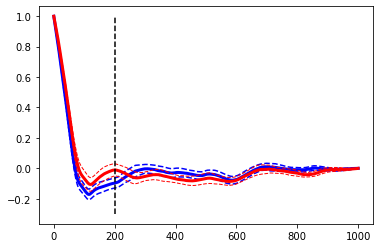

In [8]:
chain_2obj = opt.chain
fit_acorr,fit_acorr_error = opt.autocorrelation_fun(chain_2obj.bestpar)
fit_acorr = np.mean(fit_acorr[0],axis=1)

plt.plot(fit_acorr,'b',lw=3)
plt.plot(fit_acorr-fit_acorr_error[0],'b--')
plt.plot(fit_acorr+fit_acorr_error[0],'b--')


plt.plot(np.mean(opt.data_obj.acorr[0],axis=1),'r',lw=3)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) -opt.data_obj.acorr_err[0] ,'r--',lw=1)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) +opt.data_obj.acorr_err[0] ,'r--',lw=1)

plt.plot([200,200],[-.3,1],'k--')



C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Text(0, 0.5, 'Ke')

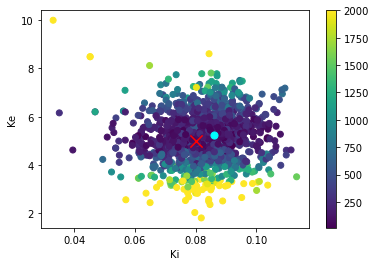

In [9]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 2000)

colors = chain_2obj.evalchain
colors[colors>2000] = 2000
viridis(colors)

fig,ax = plt.subplots(1,1)
b = ax.scatter(chain_2obj.parchain[1:,0],chain_2obj.parchain[1:,1], c = colors)
a = ax.scatter([0.08],[5],color='red',s=150,marker='x',vmin=0, vmax=2000)
a = ax.scatter([chain_2obj.bestpar[0]],[chain_2obj.bestpar[1]],color='cyan',s=50,marker='o',vmin=0, vmax=2000)

fig.colorbar(b, ax=ax)
ax.set_xlabel('Ki')
ax.set_ylabel('Ke')

In [10]:
chain_2obj.bestpar

array([0.08599964, 5.2304264 ])